## **Load libraries**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from google.colab.patches import cv2_imshow
import skimage.io
import skimage.transform
from PIL import Image
import io

## **Convert dataset to tfrecords**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the paths to the directories
full_dose_soft_3mm_path = '/content/drive/MyDrive/Preprocessed_512x512_ct/512/Full Dose/3mm/Soft Kernel (B30)'
quarter_dose_sharp_1mm_path = '/content/drive/MyDrive/Preprocessed_512x512_ct/512/Quarter Dose/1mm/Sharp Kernel (D45)'

In [ ]:
def get_image_paths(base_dir):
    image_paths = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                image_paths.append(os.path.join(root, file))
    return image_paths

In [ ]:
full = get_image_paths(full_dose_soft_3mm_path)
quarter = get_image_paths(quarter_dose_sharp_1mm_path)

In [ ]:
# Assign labels
full_dose_labels = [0] * len(full)
quarter_dose_labels = [1] * len(quarter)

# Combine the lists
file_paths = full + quarter
labels = full_dose_labels + quarter_dose_labels

In [ ]:
print(len(file_paths), len(labels))

8314 8314


In [ ]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):  # if value is tensor
        value = value.numpy()  # get value of tensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def image_example(image_string, label):
    """Creates a tf.train.Example message ready to be written to a file."""
    feature = {
        'image': _bytes_feature(image_string),
        'label': _int64_feature(label),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [ ]:
def convert_to_tfrecords(image_paths, labels, output_file):
    with tf.io.TFRecordWriter(output_file) as writer:
        count = 0
        for image_path, label in zip(image_paths, labels):
            image_string = open(image_path, 'rb').read()  # Read image file as bytes
            tf_example = image_example(image_string, label)
            writer.write(tf_example.SerializeToString())
            count += 1
            print(count)

In [ ]:
output_file = '/content/output.tfrecords'
convert_to_tfrecords(file_paths, labels, output_file)

Streaming output truncated to the last 5000 lines.
3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504

## **Save tfrecords dataset in drive**

In [ ]:
!cp /content/output.tfrecords /content/drive/MyDrive

In [ ]:
dataset_size = sum(1 for _ in raw_image_dataset)
print("Dataset size:", dataset_size)

Dataset size: 8314


## **Load tfrecords dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
output_file = '/content/drive/MyDrive/output.tfrecords'

In [ ]:
raw_dataset = tf.data.TFRecordDataset(output_file)

# Create a dictionary describing the features.
image_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_image_function(example_proto):
    # Parse the input `tf.train.Example` proto using the dictionary above.
    features = tf.io.parse_single_example(example_proto, image_feature_description)
    image_raw = features['image']
    image = tf.image.decode_png(image_raw, channels=3)  # Assuming PNG images
    image = tf.image.resize(image, [28, 28])/255.0
    image = tf.cast(image, tf.float32)
    label = features['label']
    return image, label

parsed_dataset = raw_dataset.map(_parse_image_function)

In [ ]:
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
iterator = iter(parsed_dataset)

In [ ]:
parsed_dataset

<_MapDataset element_spec=(TensorSpec(shape=(28, 28, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
parsed_dataset.element_spec

(TensorSpec(shape=(28, 28, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
iterator

In [ ]:
next(iterator)

(<tf.Tensor: shape=(28, 28, 3), dtype=float32, numpy=
 array([[[0.00342137, 0.00342137, 0.00342137],
         [0.00158063, 0.00158063, 0.00158063],
         [0.01092437, 0.01092437, 0.01092437],
         ...,
         [0.01092445, 0.01092445, 0.01092445],
         [0.01176471, 0.01176471, 0.01176471],
         [0.00996395, 0.00996395, 0.00996395]],
 
        [[0.00812324, 0.00812324, 0.00812324],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00196078, 0.00196078, 0.00196078],
         ...,
         [0.01098447, 0.01098447, 0.01098447],
         [0.00448184, 0.00448184, 0.00448184],
         [0.00298103, 0.00298103, 0.00298103]],
 
        [[0.00590236, 0.00590236, 0.00590236],
         [0.00812324, 0.00812324, 0.00812324],
         [0.00626252, 0.00626252, 0.00626252],
         ...,
         [0.01250524, 0.01250524, 0.01250524],
         [0.01456577, 0.01456577, 0.01456577],
         [0.00478208, 0.00478208, 0.00478208]],
 
        ...,
 
        [[0.01594649, 0.01594649, 

In [ ]:
image_features = iterator.next()

In [ ]:
len(image_features)

2

In [ ]:
image_features[1]

<tf.Tensor: shape=(), dtype=int64, numpy=0>

Text(0.5, 1.0, '0')

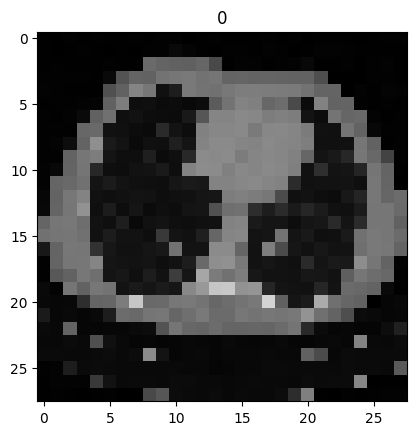

In [ ]:
plt.imshow(image_features[0], cmap='gray')
plt.title(image_features[1].numpy())

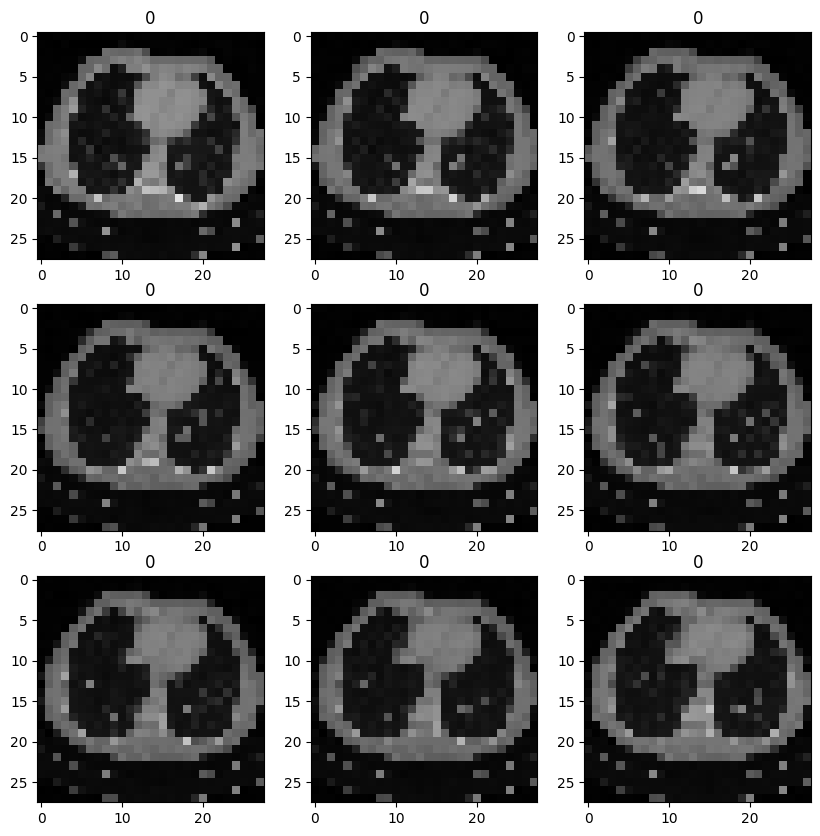

In [ ]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(parsed_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))

In [ ]:
batched_dataset = parsed_dataset.shuffle(32)

In [ ]:
batched_dataset = batched_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
BATCH_SIZE = 64
batched_dataset = batched_dataset.batch(BATCH_SIZE)

In [ ]:
batched_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
iterator = iter(batched_dataset)

In [ ]:
batch = next(iterator)

In [ ]:
len(batch)

2

In [ ]:
len(batch[0])

64

In [ ]:
batch[1]

<tf.Tensor: shape=(64,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>

## **Seperate into full and quarter dose**

In [ ]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):  # if value is tensor
        value = value.numpy()  # get value of tensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
def filter_full_dose(image, label):
  return label == 0

def filter_quarter_dose(image, label):
  return label == 1

full_dose_dataset = parsed_dataset.filter(filter_full_dose)
quarter_dose_dataset = parsed_dataset.filter(filter_quarter_dose)

def serialize_example(image, label):
  feature = {
      'image': _bytes_feature(tf.image.encode_png(tf.cast(image * 255, tf.uint8)).numpy()),
      'label': _int64_feature(label),
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

def write_tfrecords(dataset, output_file):
  with tf.io.TFRecordWriter(output_file) as writer:
    count = 0
    for image, label in dataset:
      example = serialize_example(image, label)
      writer.write(example)
      count += 1
      print(count)

# Write full dose images to TFRecord file
write_tfrecords(full_dose_dataset, '/content/full_dose.tfrecords')

# Write quarter dose images to TFRecord file
write_tfrecords(quarter_dose_dataset, '/content/quarter_dose.tfrecords')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234


KeyboardInterrupt: 

In [ ]:
# Count images in full_dose.tfrecords
full_dose_count = sum(1 for _ in tf.data.TFRecordDataset('/content/full_dose.tfrecords'))
print("Number of images in full_dose.tfrecords:", full_dose_count)

# Count images in quarter_dose.tfrecords
quarter_dose_count = sum(1 for _ in tf.data.TFRecordDataset('/content/quarter_dose.tfrecords'))
print("Number of images in quarter_dose.tfrecords:", quarter_dose_count)

Number of images in full_dose.tfrecords: 0


NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} /content/quarter_dose.tfrecords; No such file or directory [Op:IteratorGetNext] name: 

In [ ]:
!cp /content/full_dose.tfrecords /content/drive/MyDrive
!cp /content/quarter_dose.tfrecords /content/drive/MyDrive

## **Load full and quarter dose**

In [ ]:
# Load full dose dataset
full_dose_dataset = tf.data.TFRecordDataset('/content/drive/MyDrive/full_dose.tfrecords')
full_dose_dataset = full_dose_dataset.map(_parse_image_function)

# Load quarter dose dataset
quarter_dose_dataset = tf.data.TFRecordDataset('/content/drive/MyDrive/quarter_dose.tfrecords')
quarter_dose_dataset = quarter_dose_dataset.map(_parse_image_function)

In [ ]:
full_dose_dataset

<_MapDataset element_spec=(TensorSpec(shape=(28, 28, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
full_dose_dataset = full_dose_dataset.shuffle(32)
full_dose_dataset = full_dose_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
full_dose_dataset = full_dose_dataset.batch(BATCH_SIZE)

In [ ]:
quarter_dose_dataset = quarter_dose_dataset.shuffle(32)
quarter_dose_dataset = quarter_dose_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
quarter_dose_dataset = quarter_dose_dataset.batch(BATCH_SIZE)

## **Compressive Sensing**

In [ ]:
!pip install numpy scipy matplotlib cvxpy

In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 29.3 MB/s eta 0:00:00


In [ ]:
import pywt
import pywt.data

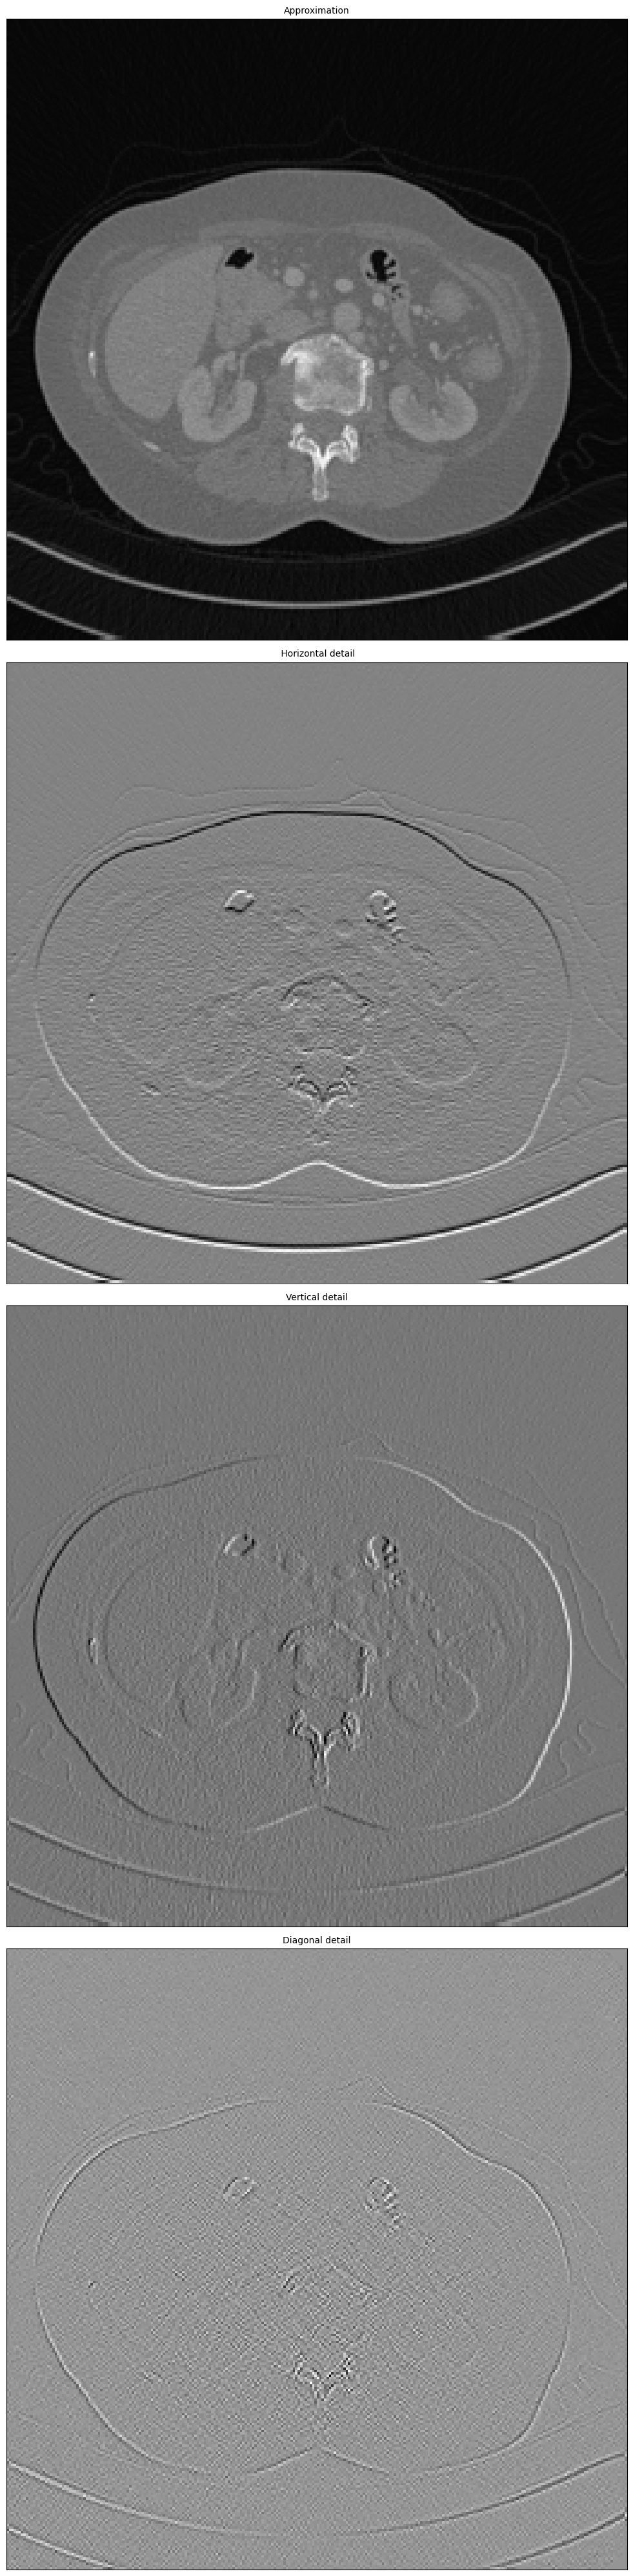

In [ ]:
original = '/content/drive/MyDrive/L192_QD_1_1.CT.0004.0207.2015.12.22.20.43.43.507395.358709522.png'
original = cv2.imread(original, cv2.IMREAD_GRAYSCALE)

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(10, 10*4))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(4, 1, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [ ]:
undersample_rate = .5
n = original.shape[0] * original.shape[1]
original_undersampled = ( original.reshape(-1) \
    * np.random.permutation(
        np.concatenate(
            (np.ones( int( n * undersample_rate ) ),
             np.zeros( int( n * ( 1-undersample_rate )) ))
        )
    )
                        ).reshape(512,512)

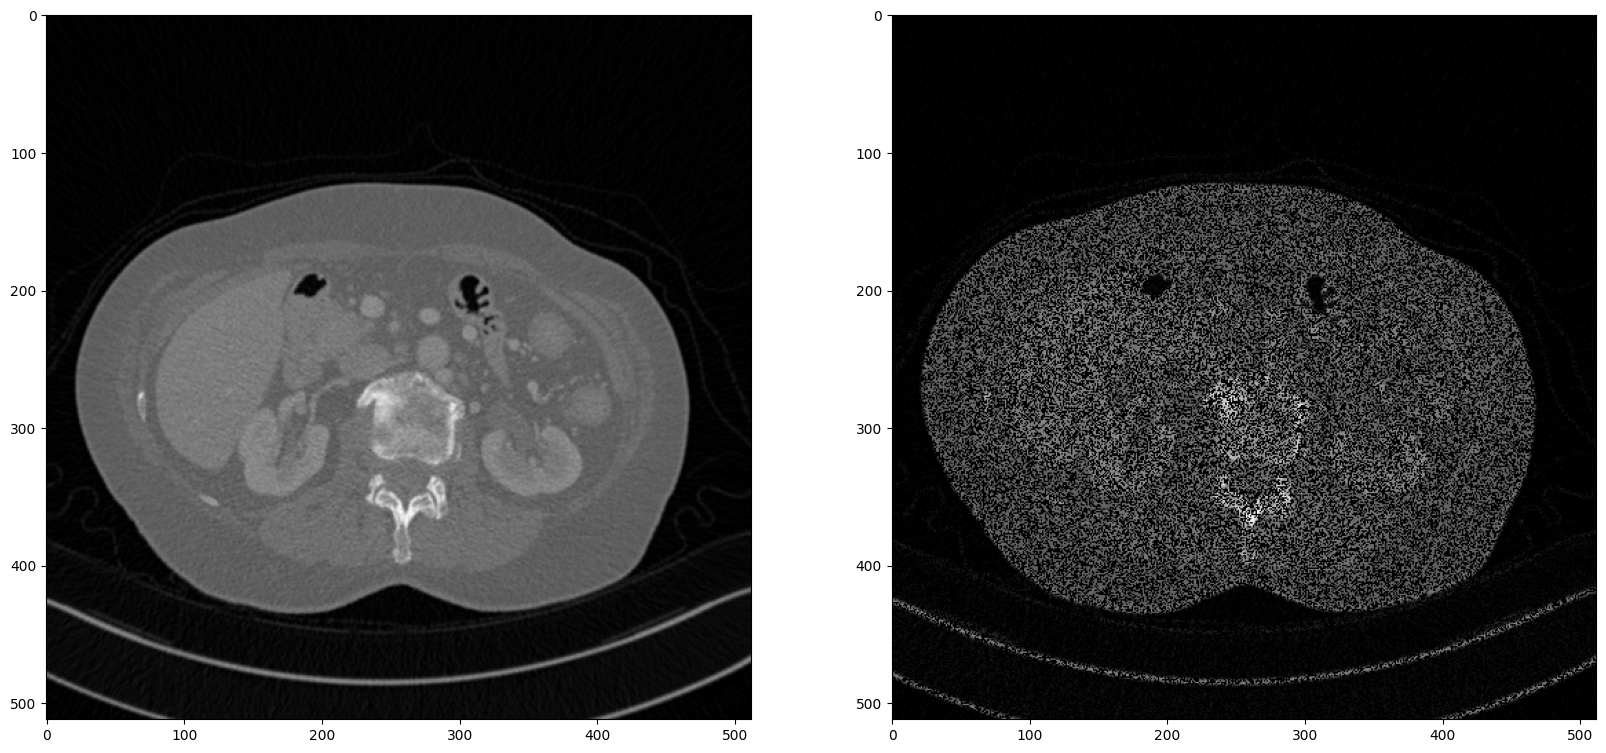

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(original, cmap=plt.cm.gray)
ax[1].imshow(original_undersampled,cmap=plt.cm.gray)

In [ ]:
def flat_wavelet_transform2(x, method='bior1.3'):
    """For a 2D image x, take the wavelet """
    coeffs = pywt.wavedec2( x, method )
    output = coeffs[0].reshape(-1)
    for tups in coeffs[1:]:
        for c in tups:
            output = np.concatenate((output, c.reshape(-1)))
    return output

def inverse_flat_wavelet_transform2(X,  shape, method='bior1.3'):
    shapes = pywt.wavedecn_shapes( shape , method)
    nx = shapes[0][0]
    ny = shapes[0][1]
    n = nx * ny
    coeffs = [X[:n].reshape(nx,ny) ]
    for i, d in enumerate(shapes[1:]):
        vals=list(d.values())
        nx = vals[0][0]
        ny = vals[0][1]
        coeffs.append( (X[ n : n + nx * ny].reshape( nx, ny ),
                        X[ n + nx * ny : n + 2 * nx * ny ].reshape( nx, ny ),
                        X[ n + 2 * nx * ny : n + 3 * nx * ny ].reshape( nx, ny ))  )
        n += 3 * nx * ny
    return pywt.waverec2(coeffs, method)

In [ ]:
def flat_wavelet_transform2(x, method='bior1.3'):
    """For a 2D image x, take the wavelet """
    coeffs = pywt.wavedec2( x, method )
    output = coeffs[0].reshape(-1)
    for tups in coeffs[1:]:
        for c in tups:
            output = np.concatenate((output, c.reshape(-1)))
    return output

def inverse_flat_wavelet_transform2(X,  shape, method='bior1.3'):
    shapes = pywt.wavedecn_shapes( shape , method)
    nx = shapes[0][0]
    ny = shapes[0][1]
    n = nx * ny
    coeffs = [X[:n].reshape(nx,ny) ]
    for i, d in enumerate(shapes[1:]):
        vals=list(d.values())
        nx = vals[0][0]
        ny = vals[0][1]
        coeffs.append( (X[ n : n + nx * ny].reshape( nx, ny ),
                        X[ n + nx * ny : n + 2 * nx * ny ].reshape( nx, ny ),
                        X[ n + 2 * nx * ny : n + 3 * nx * ny ].reshape( nx, ny ))  )
        n += 3 * nx * ny
    return pywt.waverec2(coeffs, method)

Text(0.5, 1.0, 'A small sample of the wavelet transform')

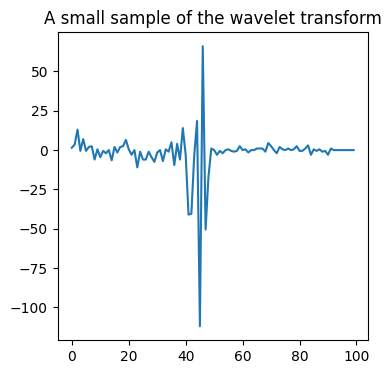

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(flat_wavelet_transform2(original_undersampled, 'bior1.3')[-100:] )
plt.title('A small sample of the wavelet transform')

Text(0.5, 1.0, 'A small sample of the wavelet transform')

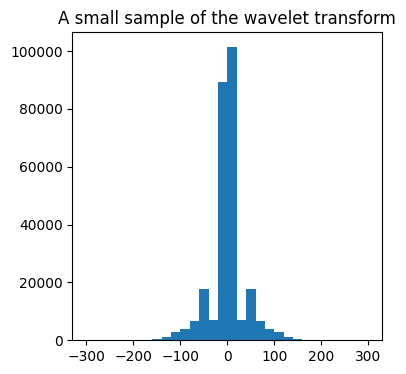

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(flat_wavelet_transform2(original_undersampled, 'bior1.3') , range=(-300,300), bins=30)
plt.title('A small sample of the wavelet transform')

In [ ]:
def soft_thresh(x, lam):
    if ~(isinstance(x[0], complex)):
        return np.zeros(x.shape) + (x + lam) * (x<-lam) + (x - lam) * (x>lam)
    else:
        return np.zeros(x.shape) + ( abs(x) - lam ) / abs(x) * x * (abs(x)>lam)

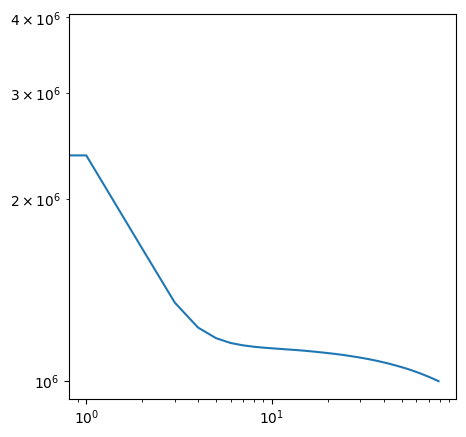

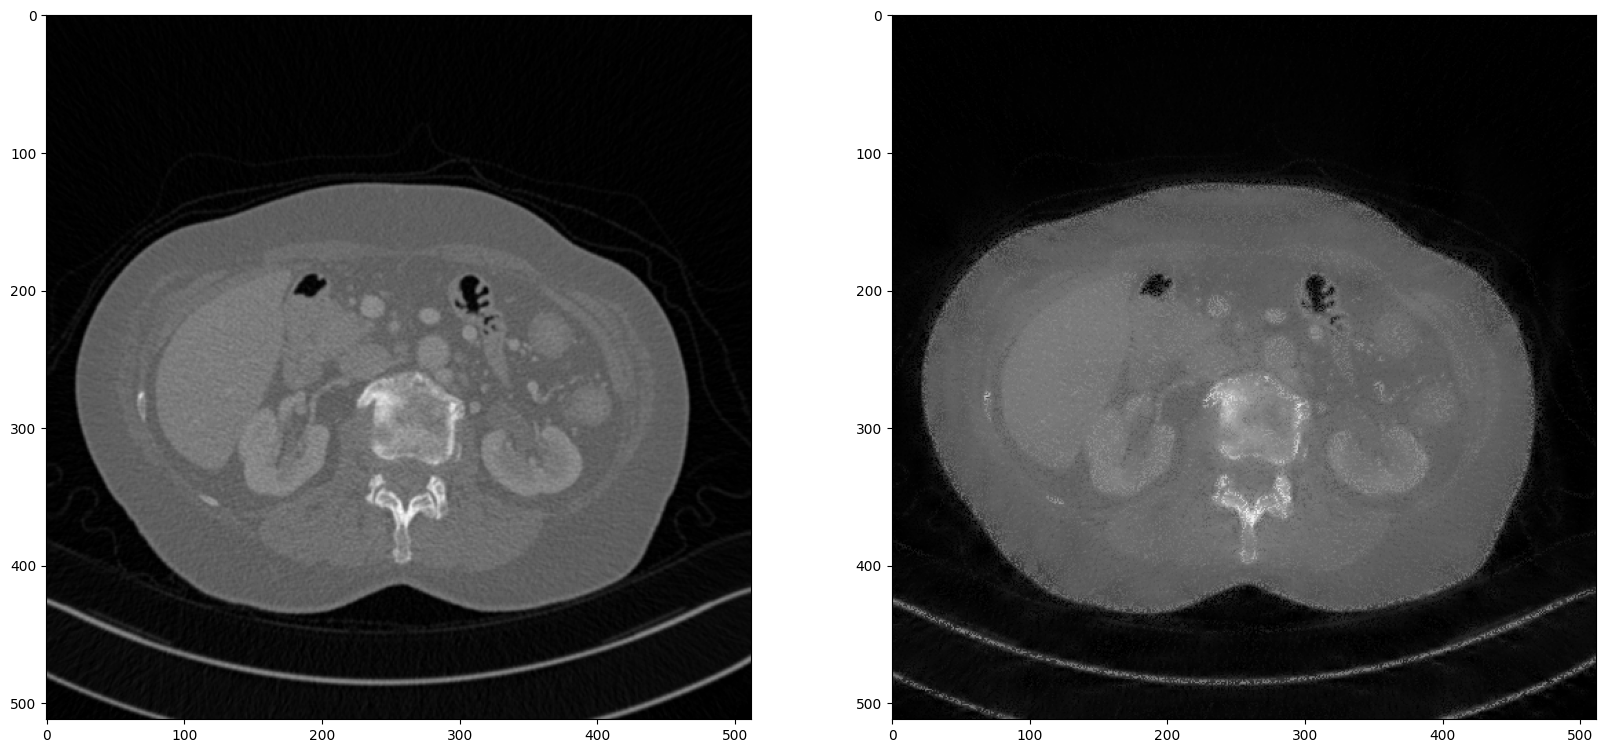

In [ ]:
methods = ['haar','coif1','coif2','coif3','bior1.1','bior1.3','bior3.1','bior3.3','rbio1.1','rbio1.3','rbio3.1','rbio3.3']
def distance(x,y):
    return sum(abs(x.reshape(-1)-y.reshape(-1)))

# undersampled noisy signal in image-space and let this be first order Xhat
y = original_undersampled

# Repeat steps 1-4 until change is below a threshold
eps = 1e-2
lam = 100
lam_decay = 0.995
minlam = 1

err2=[]


lam = 100


xhat = y.copy()
for i in range(80):
    method = 'sym3'
    xhat_old = xhat
    Xhat_old = flat_wavelet_transform2(xhat, method)
    Xhat = soft_thresh(Xhat_old, lam)
    xhat = inverse_flat_wavelet_transform2(Xhat, (512,512), method)
    xhat[y!=0] = y[y!=0]


    xhat = xhat.astype(int)
    xhat[xhat<0] = 0
    xhat[xhat>255] = 255
    err2.append(distance(original, xhat))
    lam *= lam_decay
#     if (distance(xhat, xhat_old)<eps):
#         break




fig = plt.figure(figsize=(5,5))
plt.loglog(err2)


fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(original, cmap=plt.cm.gray)
ax[1].imshow(xhat,cmap=plt.cm.gray, vmin=0, vmax=255)

In [ ]:

output_path = '/content/drive/MyDrive/processed_image.png'  # Change the path as needed
cv2.imwrite(output_path, xhat)


True

## **Attentive GAN**

In [ ]:
from tensorflow.keras import layers, models

In [ ]:
import keras

In [ ]:
def build_generator(latent_dim, image_shape=(28, 28, 3)):
    # Image input (instead of label input)
    in_image = layers.Input(shape=image_shape)
    # Downsample the image to match the dimensions for concatenation
    li = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(in_image)
    li = layers.LeakyReLU(alpha=0.2)(li)
    li = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(li)
    li = layers.LeakyReLU(alpha=0.2)(li)
    li = layers.Flatten()(li)
    li = layers.Dense(7 * 7 * 1)(li)
    li = layers.Reshape((7, 7, 1))(li)

    # Latent vector input
    in_lat = layers.Input(shape=(latent_dim,))
    # Foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = layers.Dense(n_nodes)(in_lat)
    gen = layers.LeakyReLU(alpha=0.2)(gen)
    gen = layers.Reshape((7, 7, 128))(gen)

    # Merge image input and latent vector
    merge = layers.Concatenate()([gen, li])

    # Upsample to 14x14
    gen = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same',
                                 activation=layers.LeakyReLU(alpha=0.2))(merge)
    gen = layers.BatchNormalization()(gen)

    # Upsample to 28x28
    gen = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same',
                                 activation=layers.LeakyReLU(alpha=0.2))(gen)
    gen = layers.BatchNormalization()(gen)

    # Output layer
    out_layer = layers.Conv2D(3, (7, 7), activation='tanh', padding='same')(gen)

    # Define model
    model = models.Model([in_lat, in_image], out_layer)
    return model

In [ ]:
generator = build_generator(128)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 14, 14, 64)     │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 128)      │         73,856 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 7, 7, 128)      │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 6272)           │        809,088 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 6272)           │              0 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 6272)           │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 49)             │        307,377 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 7, 7, 128)      │              0 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 7, 7, 1)        │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 7, 7, 129)      │              0 │ reshape_1[0][0],       │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 14, 14, 128)    │        264,320 │ concatenate[0][0]      │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 14, 14, 128)    │            512 │ conv2d_transpose[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 28, 28, 128)    │        262,272 │ batch_normalization[0… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 28, 28, 128)    │            512 │ conv2d_transpose_1[0]… │
│ (BatchNormalization) 

 Total params: 1,738,548 (6.63 MB)

 Trainable params: 1,738,036 (6.63 MB)

 Non-trainable params: 512 (2.00 KB)

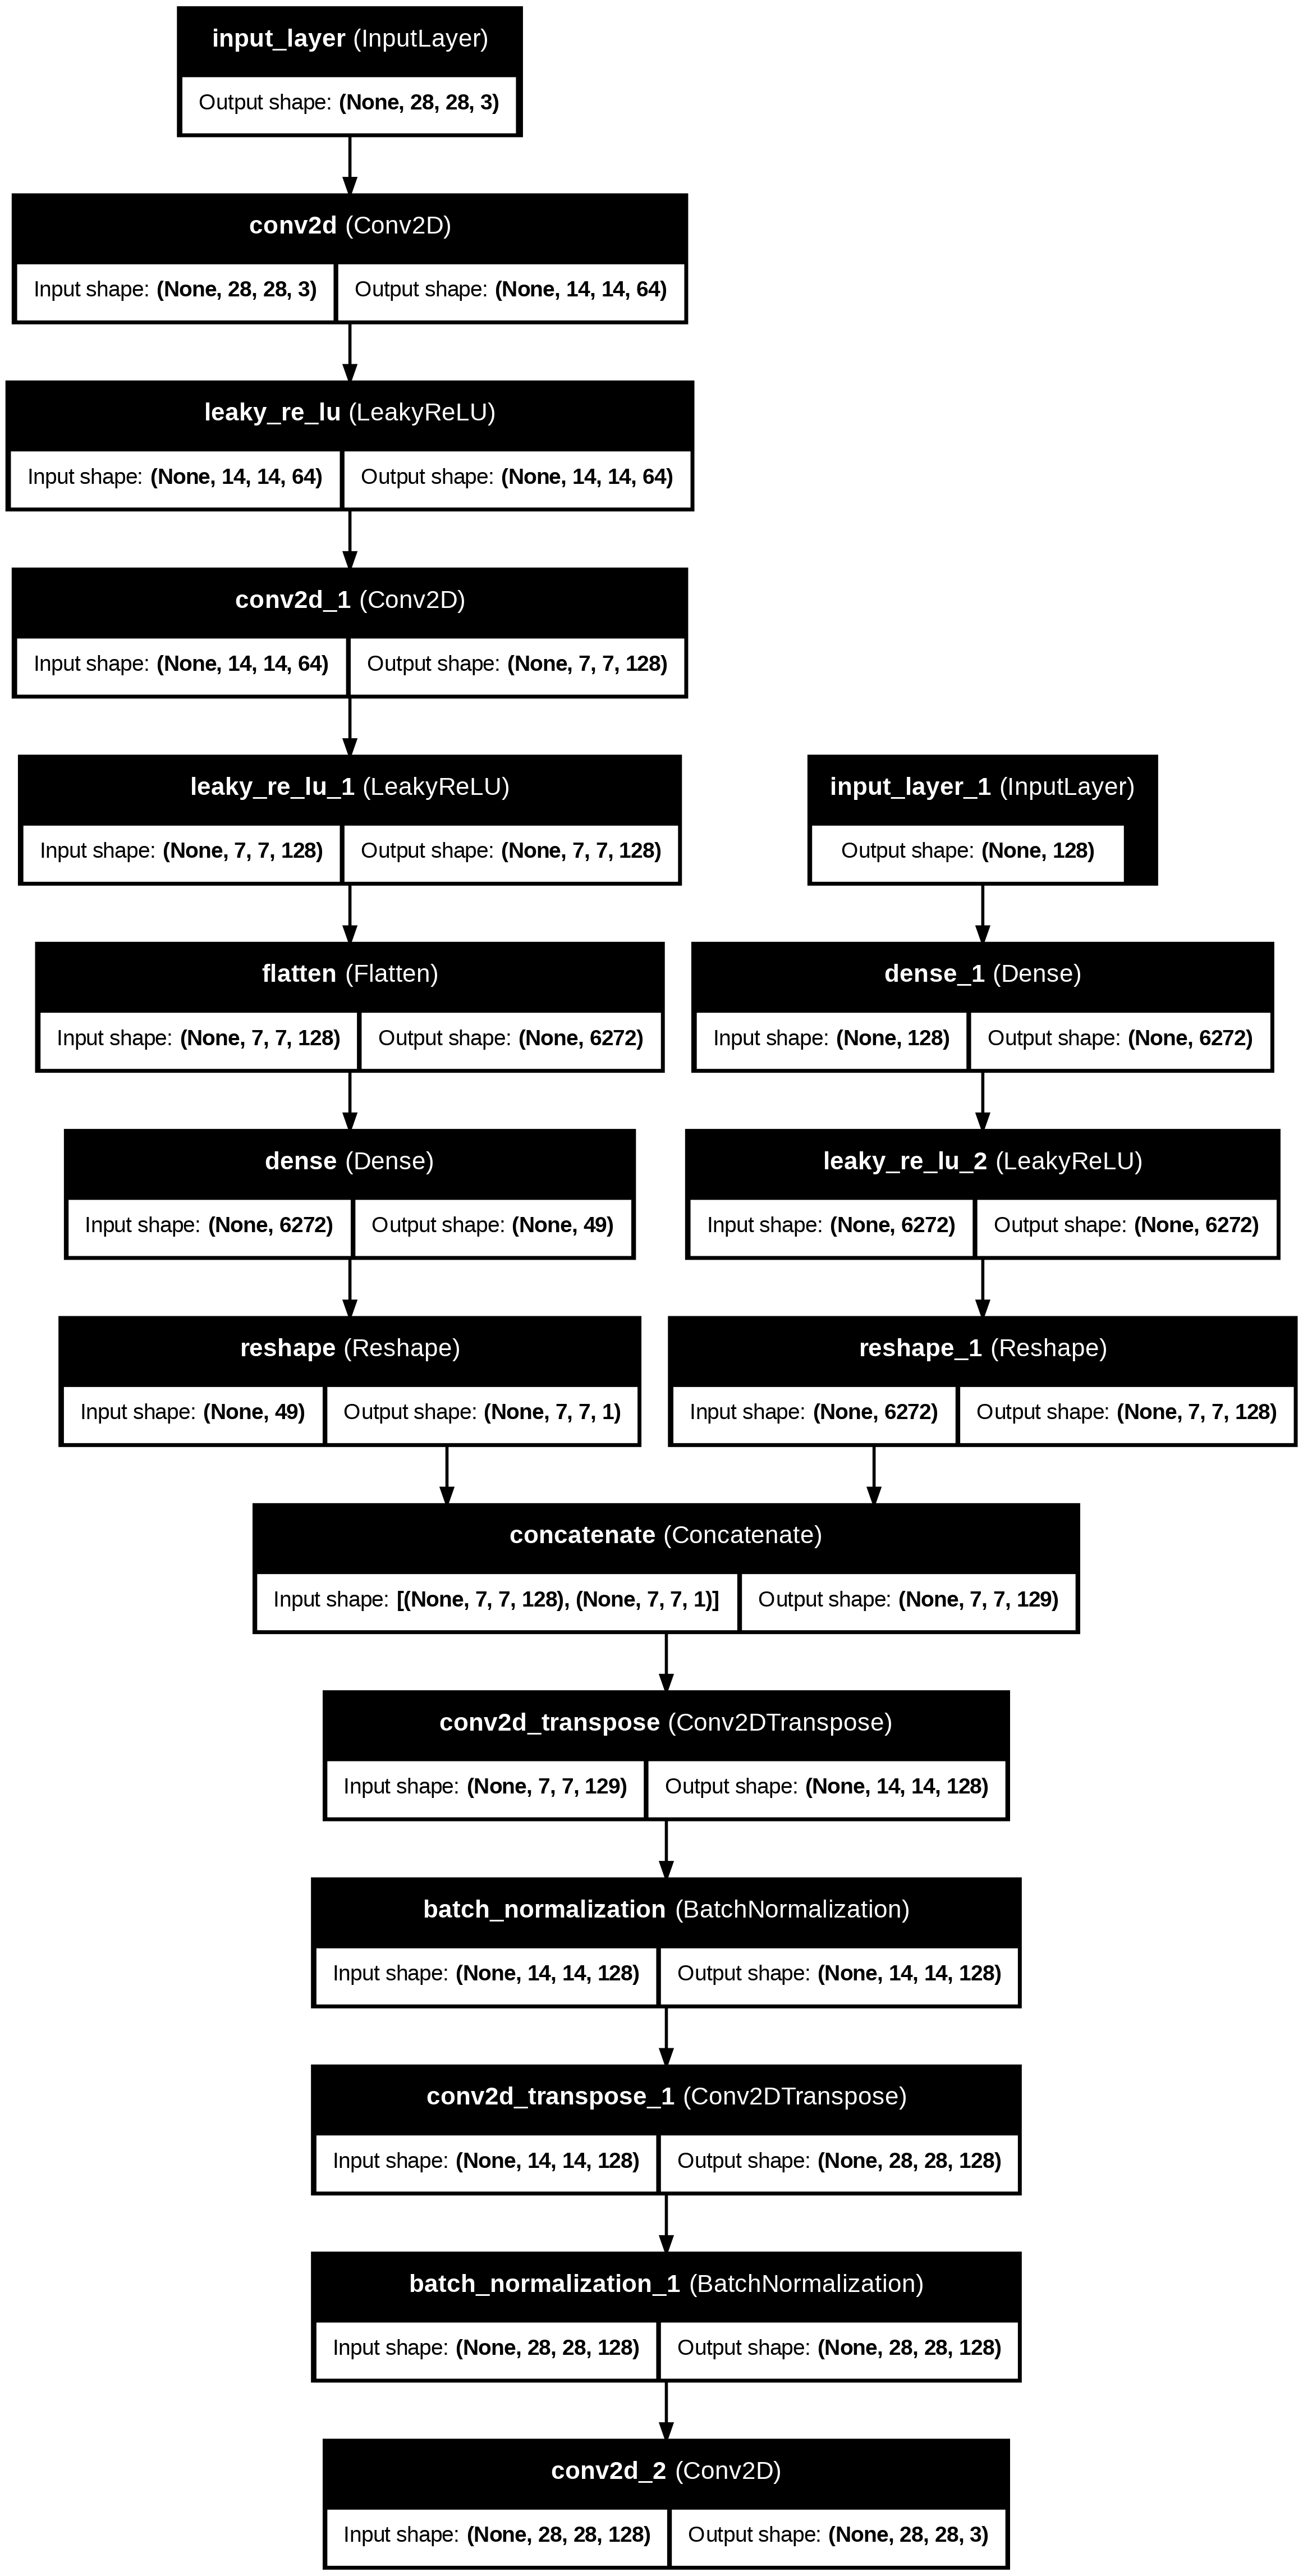

In [ ]:
keras.utils.plot_model(generator, show_shapes=True, show_layer_names=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


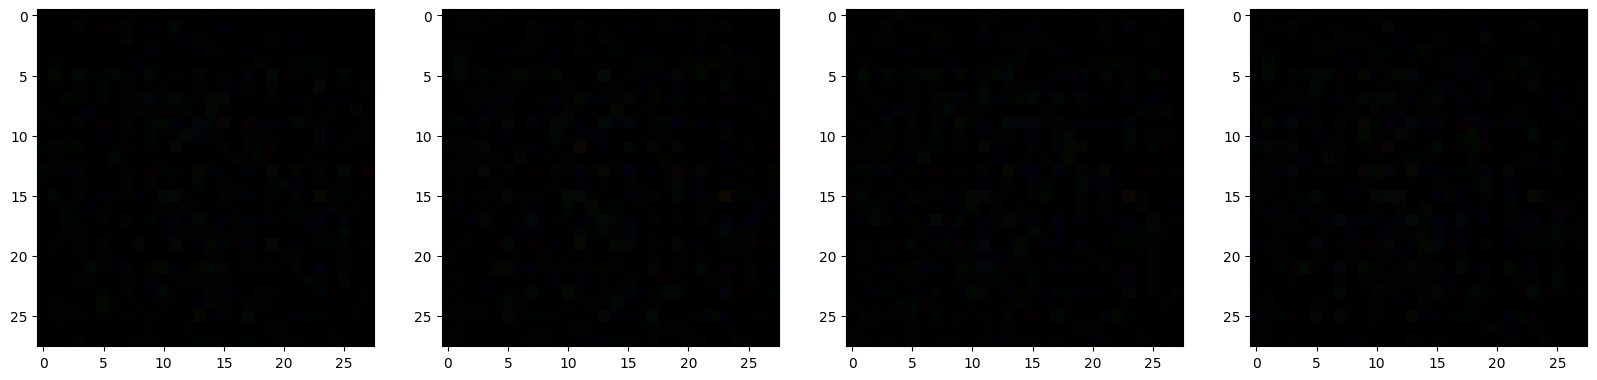

In [ ]:
img = generator.predict([np.random.rand(4, 128), np.random.rand(4, 28, 28, 3)])

# Display the images
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for i in range(4):
    ax[i].imshow(np.squeeze(img[i]), cmap='gray')
plt.show()

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, Flatten, Dense

def build_discriminator(input_shape=(28, 28, 3)):
    model = Sequential()

    # First Conv2D block
    model.add(Conv2D(32, kernel_size=(5, 5), padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    # Second Conv2D block
    model.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    # Third Conv2D block
    model.add(Conv2D(128, kernel_size=(5, 5), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    # Fourth Conv2D block
    model.add(Conv2D(256, kernel_size=(5, 5), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator = build_discriminator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
discriminator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │         200,705 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,278,785 (4.88 MB)

 Trainable params: 1,278,785 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

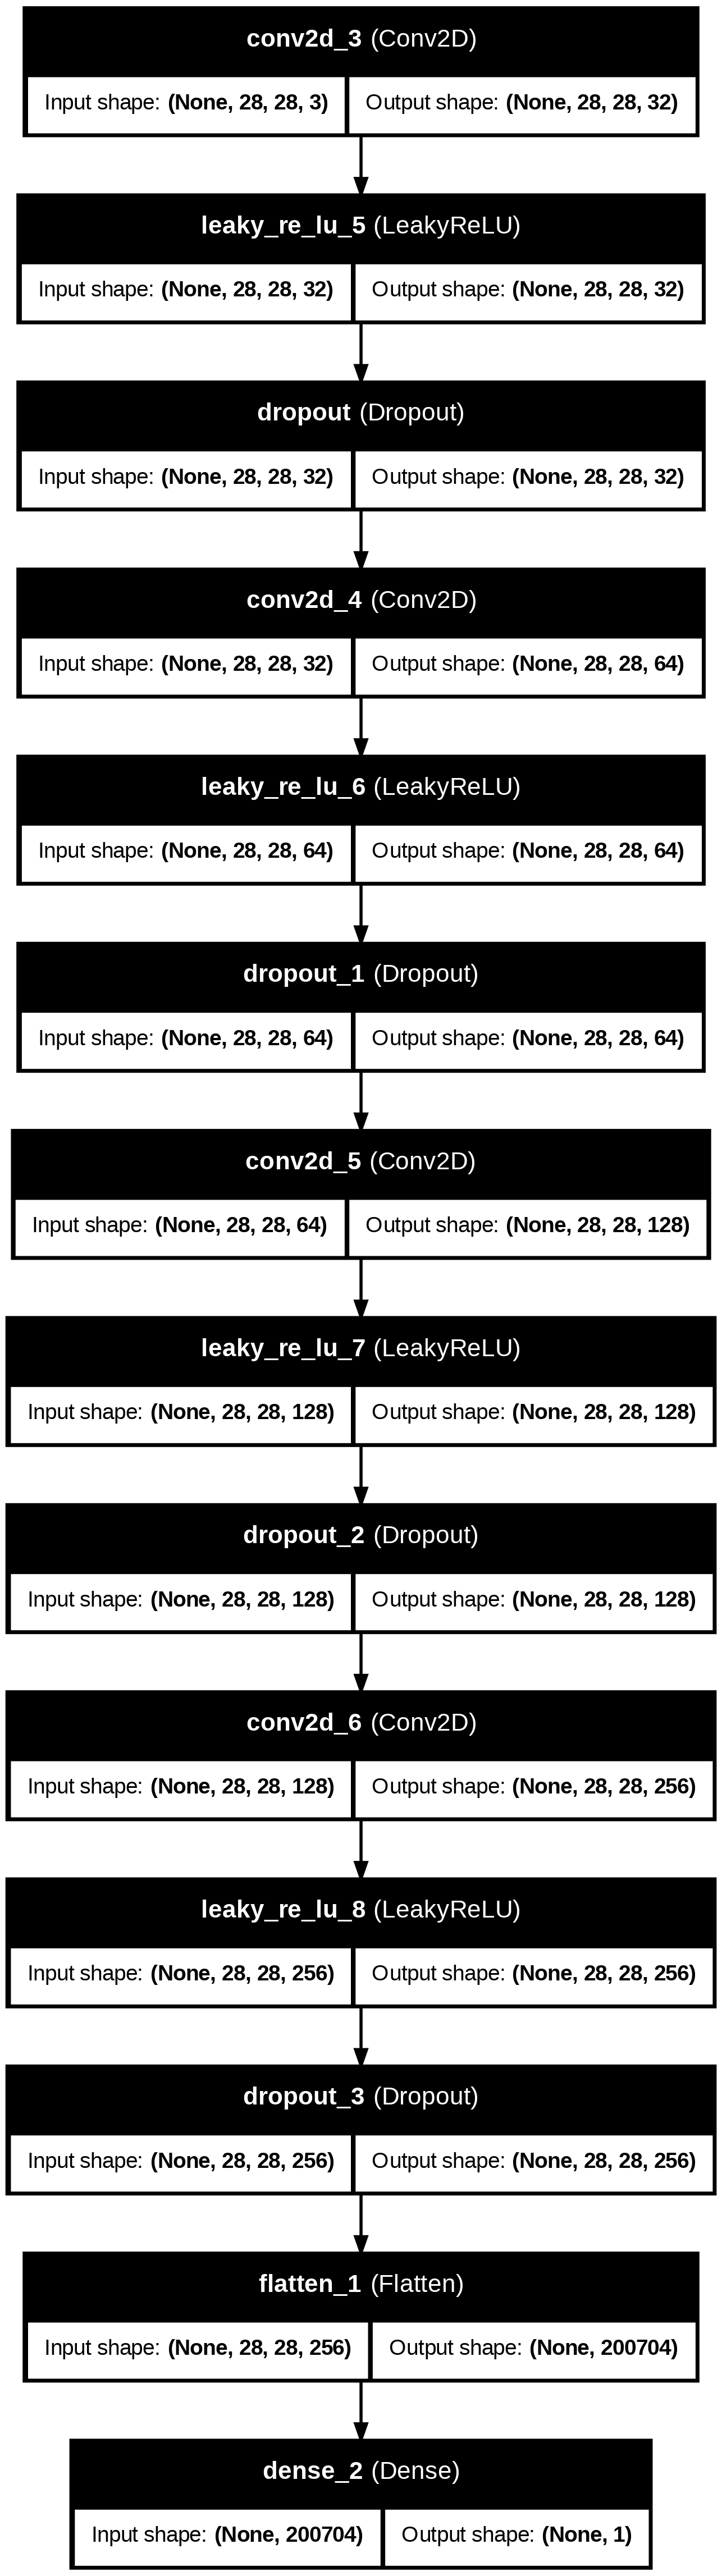

In [ ]:
keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
# learning rate for discriminator is lesser than that of generator
g_opt = Adam(learning_rate=0.0002)
d_opt = Adam(learning_rate=0.00002)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
class GAN(Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss):
        super(GAN, self).compile()
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the real images from the batch
        real_images = batch

        # Generate random latent vectors
        batch_size = 64
        latent_dim = self.generator.input_shape[0][1]  # assumes the first input is the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))

        # Create random images as labels (change to match your generator input)
        random_images = tf.random.normal(shape=(batch_size, *self.generator.input_shape[1][1:]))

        random_images = tf.cast(random_images, dtype=tf.float32)

        # Generate fake images using the generator
        fake_images = self.generator([random_latent_vectors, random_images], training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Get predictions for real and fake images
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fake images
            y_real = tf.ones_like(yhat_real)
            y_fake = tf.zeros_like(yhat_fake)
            y_realfake = tf.concat([y_real, y_fake], axis=0)

            # Add some noise to the labels
            noise_real = 0.15 * tf.random.normal(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.normal(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate the discriminator loss
            d_loss_value = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation for the discriminator
        d_gradients = d_tape.gradient(d_loss_value, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate fake images again (for generator training)
            fake_images = self.generator([random_latent_vectors, random_images], training=True)

            # Get the discriminator's predictions on the fake images
            predicted_labels = self.discriminator(fake_images, training=False)

            # Calculate the generator loss (flipping the labels)
            g_loss_value = self.g_loss(tf.ones_like(predicted_labels), predicted_labels)

        # Apply backpropagation for the generator
        g_gradients = g_tape.gradient(g_loss_value, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        return {'d_loss': d_loss_value, 'g_loss': g_loss_value}

In [ ]:
# create instance of model
gan = GAN(generator, discriminator)

In [ ]:
# compile the model
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [ ]:
from keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
# train the model
hist = gan.fit(batched_dataset, epochs=100)

Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - d_loss: 0.0208 - g_loss: 0.6619
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - d_loss: 0.0269 - g_loss: 0.1606
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - d_loss: 0.0133 - g_loss: 1.4886
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - d_loss: 0.0127 - g_loss: 0.6554
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - d_loss: -0.0090 - g_loss: 1.5804
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - d_loss: 0.0182 - g_loss: 3.0490
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - d_loss: -0.0020 - g_loss: 1.9246
Epoch 8/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - d_loss: -0.0208 - g_loss: 0.3995
Epoch 9/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - d_loss: 0.0208 - g_loss: 1.7397
Epoch 10/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - d_loss: -0.0243 - g_loss: 2.8368
Epoch 11/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - d_loss: 0.0041 - g_loss: 4.1781
Epoc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


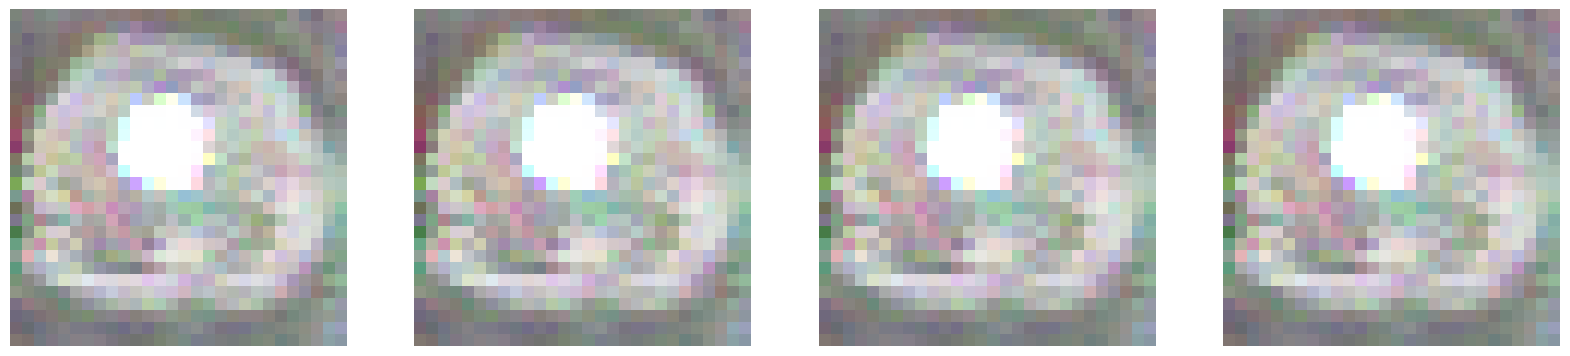

In [ ]:
latent_dim = 128
n_samples = 4  # Number of images to generate

# Generate random latent vectors
noise = np.random.normal(0, 1, (n_samples, latent_dim))

# Create random images to serve as the second input
# Assuming your generator expects an input image of shape (28, 28, 3)
random_images = np.random.normal(0, 1, (n_samples, 28, 28, 3))

# Generate images using the generator
generated_images = gan.generator.predict([noise, random_images])

# Display generated images
fig, ax = plt.subplots(ncols=n_samples, figsize=(20, 20))
for i in range(n_samples):
    ax[i].imshow((generated_images[i] + 1) / 2)  # Rescale from [-1, 1] to [0, 1] if using tanh activation
    ax[i].axis('off')
plt.show()

In [ ]:
gan.save('/content/drive/MyDrive/my_gan_model.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:102: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [ ]:
!git init

Reinitialized existing Git repository in /content/.git/


In [ ]:
!git remote add origin https://github.com/shreeya1810/ct.git

error: remote origin already exists.


In [ ]:
!git branch -M main

In [ ]:
!git add .

In [ ]:
!git ls-tree -r main --name-only

.config/.last_opt_in_prompt.yaml
.config/.last_survey_prompt.yaml
.config/.last_update_check.json
.config/active_config
.config/config_sentinel
.config/configurations/config_default
.config/default_configs.db
.config/gce
.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
.config/logs/2024.08.09/13.21.31.474641.log
.config/logs/2024.08.09/13.21.52.633196.log
.config/logs/2024.08.09/13.22.02.230892.log
.config/logs/2024.08.09/13.22.03.330412.log
.config/logs/2024.08.09/13.22.12.955173.log
.config/logs/2024.08.09/13.22.13.565225.log
sample_data/README.md
sample_data/anscombe.json
sample_data/california_housing_test.csv
sample_data/california_housing_train.csv
sample_data/mnist_test.csv
sample_data/mnist_train_small.csv
